<h1><center>DATA EXPLORATION</center></h1>

We have collected information of over 6000 films from 1950 to 2018 including their director, cats, crew, budget, box-office revenues, running-time, and the genres they fall into. We have also obtained data about Academy Awards winners and nominees from 1955 to 2019 both at the level of films and the level of individuals. 

Our first goal is to explore the data and ensure consistency and integrity. We will then do some poreliminarfy analysis a out the various trends in predicting movie success b ased on revenues, IMDB votes and Academyy Award wins and nominations. 

Next, we will derive some new datasets which will be used for building and training our machine learning pipleines. The key factors we will be considering for training our models are the following:
1. Basic information about budget, revenues, IMDB ratings, length.
2. Movie genres of each film
3. Pre-oscar score computed based on the past awards and nominations of the cast, director, writer and technical staff of the film

In addition to the above, we will design a set of new features from existing features that may provide useful insights. These **derived variables** are:
1. Budget per actor: A measure of the amount spent on each cast member
2. Budget per time: A measure of amount spent per unit frame of the film
3. Runtime per actor: A measure of average screen-time allocated to each actor
4. Total ratings: To capture popularity (number of votes) and the ratings

And finally, we will be doing predictive modeling on the best film and best performance categories. The various cvategories will thus be aggregated into super-categories such as direction, performance, picture etc. 


In [1]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
plt.style.use('ggplot')
%matplotlib inline

## Data Wrangling

THe acvquired data have been collected in the following data-structres and names: <br>
**Oscar categories and movie genres** THe hand-selected standard categories for the Acaemy Awards and the movie-genres are stored in the two followiong files. 
1. genre_dict = pickle.load(open("my_data_2/genre_dict","rb"))
2. main_categories_list = pickle.load(open("my_data_2/main_categories_list","rb")) 

The following dataframes have also been created:
1. df_oscars_films: DataFrame of films with wins('W'),nominations('N') or nothing('O') froim 1960 to 2019 oscars (films from 1959 to 2018)
2. df_oscars_individual: DataFRame of invidiaul categories (direcvtorsm, actors, supporting actrors, music, editing, etc)
3. df_imdb: Dataframe of movies scraped from IMDB.com (:pages1,2,3) and Wikpedia cointaining imdbID, votes, ratings, budget, box_office, running_time and cast_size
4. movie_info_dict: Dictionary of movie information for all the films in the above data frames combined

In [2]:
# Get preselected oscars info: Genres (genre_dict) and main oscar categories (main_categories)
genre_dict = pickle.load(open("my_data_4/genre_dict","rb"))
all_categories = pickle.load(open("my_data_4/all_categories","rb")) 
major_categories = pickle.load(open("my_data_4/major_categories","rb")) 
minor_categories = pickle.load(open("my_data_4/minor_categories","rb")) 
print(major_categories)

#OSCARS information
df_oscars_wide = pd.read_csv('my_data_4/df_oscars_wide.csv', index_col=[0])
df_oscars_long = pd.read_csv('my_data_4/df_oscars_long.csv', index_col=[0])
df_individual_long = pd.read_csv('my_data_4/df_individual_long.csv', index_col=[0])
# df_oscars_wide.rename(columns = {'film':'title'},inplace=True)
df_oscars_wide.title = df_oscars_wide.title.str.replace(':','')

# Movie information (PRE 2018)
movie_dict = pickle.load(open("my_data_4/movie_dict","rb"))
df_movies = pd.read_csv('my_data_4/df_movies.csv', index_col=[0])
df_movies.title = df_movies.title.str.replace(':','')


# Remove outliers
df_movies = df_movies[(df_movies.budget>0) & (df_movies.budget<900)&
                      (df_movies.box_office > 0)&(df_movies.box_office < 5000)&
                      (df_movies.n_votes > 1000)&(df_movies.running_time>0)&
                      (df_movies.year>=1950)& (df_movies.year<2019)]
df_movies.reset_index(inplace=True,drop=True)

print(f'\nTotal movies in movie dataframe: {df_movies.shape[0]}')
print(f"No. of movies duplicated is {len(df_movies[df_movies.duplicated()])}")
print(f'Total movies in oscar dataframe: {len(df_oscars_wide.title.unique())}')
print(f'Total Individuals (actors, directors, screenwriters etc.) in individual dataframe: {len(df_individual_long.name.unique())}')


['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay']

Total movies in movie dataframe: 4718
No. of movies duplicated is 0
Total movies in oscar dataframe: 2517
Total Individuals (actors, directors, screenwriters etc.) in individual dataframe: 3378


In [3]:
movie_dict_2019 = pickle.load(open("my_data_4/movie_dict_2019","rb"))
df_movies_2019 = pd.read_csv('my_data_4/df_movies_2019.csv', index_col=[0])
df_movies_2019 = df_movies_2019[pd.notnull(df_movies_2019.cast)]
df_movies_2019 = df_movies_2019[pd.notnull(df_movies_2019.running_time)]
# df_movies_2019.info()
df_movies_2019.shape
df_movies_2019.head()

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,inflation_factor,budget_adjusted,box_office_adjusted
0,tt4154796,avengers: endgame,2019,613329,8.5,356.0,2798.0,16.0,4,181.0,0.392157,139.607843,1097.254902
1,tt1979376,toy story 4,2019,135006,7.9,200.0,1073.0,13.0,3,100.0,0.392157,78.431373,420.784314
2,tt4154664,captain marvel,2019,380206,6.9,175.0,1128.0,10.0,4,124.0,0.392157,68.627451,442.352941
3,tt6320628,spider-man: far from home,2019,238917,7.6,160.0,1132.0,10.0,4,129.0,0.392157,62.745098,443.921569
4,tt4520988,frozen ii,2019,12874,7.2,150.0,1041.0,4.0,5,103.0,0.392157,58.823529,408.235294


In [4]:
print(f'movie_dict is a dictionary containing information of {len(movie_dict)} movies')
print(f'movie_dict_2019 is a dictionary containing information of {len(movie_dict_2019)} movies')

# df_movies.to_csv('my_data_4/df_movies_budget_adjusted.csv')

movie_dict is a dictionary containing information of 6537 movies
movie_dict_2019 is a dictionary containing information of 310 movies


## The Derived Dataframe
We will create a new dataframe containing variables derived from the basic variables of the movie such as budget, cast size, running time, box office. 

In [5]:
##DF_MOVIES_DERIVED
def get_derived_dataframa(df_mov, budget_adjusted = 1):
    df_derived = pd.DataFrame()
    df_derived[['imdbID','title','year']]= df_mov[['imdbID','title','year']]
    if budget_adjusted==1:
        
        df_derived['budget_per_actor'] = df_mov.budget_adjusted/df_mov.cast
        df_derived['budget_per_time'] = df_mov.budget_adjusted/df_mov.running_time
        df_derived['runtime_per_actor'] = df_mov.running_time/df_mov.cast
        df_derived['percent_revenue'] = 100*(df_mov.box_office - df_mov.budget)/df_mov.budget #relative, not adjusted
        df_derived['total_ratings'] = df_mov.n_votes*df_mov.imdb_rating/1000
    elif budget_adjusted==0:
        df_derived['budget_per_actor'] = df_mov.budget/df_mov.cast
        df_derived['budget_per_time'] = df_mov.budget/df_mov.running_time
        df_derived['runtime_per_actor'] = df_mov.running_time/df_mov.cast
        df_derived['percent_revenue'] = 100*(df_mov.box_office - df_mov.budget)/df_mov.budget #relative, not adjusted
        df_derived['total_ratings'] = df_mov.n_votes*df_mov.imdb_rating/1000
        

    print("Output shape:",df_derived.shape)
    print("Input shape:", df_mov.shape)
    return df_derived



df_movies_derived = get_derived_dataframa(df_movies)
df_movies_derived_2019 = get_derived_dataframa(df_movies_2019)


df_movies_derived.to_csv("my_data_4/df_movies_derived.csv")
df_movies_derived_2019.to_csv("my_data_4/df_movies_derived_2019.csv")

Output shape: (4718, 8)
Input shape: (4718, 13)
Output shape: (234, 8)
Input shape: (234, 13)


## The Genre Dataframe

In [19]:
def get_movie_genres(df_movies, movie_dict, genre_dict):  
    """takes in the movie information and the genre dictionary and creates a 
    one hot encoded genre
    """
    columns = ['title', 'year', 'imdbID', 'book']  + list(set(genre_dict.values()))
    df_genre = pd.DataFrame(columns = columns)

    for row in df_movies.iterrows(): # go through each movie
        idx = row[0]
        if idx%500==0:
            clear_output()
            print(f'{idx}of {len(df_movies)}')
            
        df_genre.loc[idx,'title'] = row[1].title
        df_genre.loc[idx,'year'] = row[1].year
        df_genre.loc[idx,'imdbID'] = row[1].imdbID
        
        if (row[1].title, row[1].year) not in movie_dict:
            continue
        else:
            movie = movie_dict[(row[1].title,row[1].year)]
        
        if 'book' in movie and movie['book']=='yes':
            df_genre.loc[idx,'based_on_book']= 1
        else:
            df_genre.loc[idx,'based_on_book']=0
            
        if 'genre' in movie and movie['genre'] != None:
            for gen in movie['genre']:
                df_genre.loc[idx,gen]=1
        else:
            df_genre.loc[idx,'oth']=1

    return df_genre.fillna('0') 

In [25]:
%%time
df_movies_genres = get_movie_genres(df_movies, movie_dict, genre_dict)
print(df_movies.shape)
print(df_movies_genres.shape)
df_movies_genres.to_csv('my_data_4/df_movies_genres.csv')

df_movies_genres_2019 = get_movie_genres(df_movies_2019, movie_dict_2019, genre_dict)
print(df_movies_2019.shape)
print(df_movies_genres_2019.shape)
df_movies_genres_2019.to_csv('my_data_4/df_movies_genres_2019.csv')

0of 234
(234, 13)
(234, 31)
CPU times: user 809 ms, sys: 22.3 ms, total: 832 ms
Wall time: 838 ms


In [26]:
df_movies_genres_2019.head()

,title,year,imdbID,book,hor,fan,epi,oth,ani,rom,...,mon,cri,mys,war,adv,act,dis,thr,based_on_book,other
0,avengers: endgame,2019.0,tt4154796,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1.0,0
1,toy story 4,2019.0,tt1979376,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0.0,0
2,captain marvel,2019.0,tt4154664,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1.0,0
3,spider-man: far from home,2019.0,tt6320628,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1.0,0
4,frozen ii,2019.0,tt4520988,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0.0,0


# Overall Genre Distribution

The following distribution of genres acorss all movies considered. Drama is the most popular genre followed by comedy and action

Index(['hor', 'fan', 'epi', 'oth', 'ani', 'rom', 'dys', 'sci', 'dra', 'psy',
       'spy', 'his', 'sup', 'bio', 'com', 'mus', 'pol', 'mon', 'cri', 'mys',
       'war', 'adv', 'act', 'dis', 'thr'],
      dtype='object')
(4952, 25)
CPU times: user 89.2 ms, sys: 8.14 ms, total: 97.3 ms
Wall time: 97.8 ms


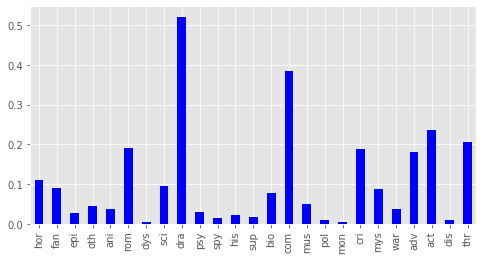

In [33]:
%%time
df_genres = df_movies_genres.append(df_movies_genres_2019)
genre_matrix=df_genres.iloc[:,4:-2].astype('int64')# .values
columns = genre_matrix.columns
print(columns)
print(genre_matrix.shape)
type(genre_matrix)


x = genre_matrix.sum(axis=0)/len(genre_matrix)
plt.figure(figsize=(8,4))
x.plot.bar(color ='b')
# plt.bar(genre_matrix.sum(axis=0)/len(genre_matrix))

## The Score Dataframe
Each movie will be assigned a prescore and a postscore. Ppre-score is the score of a film based on the track-record of its director, cast-members and other technical crew members. Post-score is based on the awards and nominations received by the film in the following year's Academy Awards.

First we will obtain the score dataframe for the oscar films and the individual nominees and winners.

In [52]:
def oscar_score(df_long,categories,years):
    """
    This returns an oscar score for each year and category, 
    both for films and individuals, based competition.
    """
    
    # initialize the score column
    scores = []
    df = pd.DataFrame()

    if categories == 'all':
        categories = pickle.load(open("my_data_3/all_categories","rb"))
    if type(categories)!=list:
        print('Error: Categories must be passed as a list')
        return
    for year in years:
        if year%10==0:
            clear_output()
            print('In decade:', year)
        for category in categories:
            # Only get winners and nominees for the year and category
            df_this = df_long[(df_long.year ==year) & (df_long.category==category)]
            if len(df_this)==0:
                print(f'Category {category} for {year} not avaialable')
                continue

            # Calculate score
            score = dict()
            n_wins = len(df_this[df_this.result=='W'])+len(df_this[df_this.result=='WN'])
            n_noms = len(df_this[df_this.result!='O'])
            
            if n_wins==0 or n_noms==0:
                print(f'No winner or nomination in {year} for category {category}')
                continue
            score['W']= min(5,n_noms/n_wins) # winner gets n points, more the competition, higher the point
            score['WN']= min(5,n_noms/n_wins)
            score['N']= 1/n_noms # nominees share, more the nominees , less each one gets 
            score['O']= 0 # else zero points (not needed, shown for consistency)
            scores = [score[x] for x in df_this.result]
            df_this['score']=scores
            scores = []
            df = df.append(df_this)
    return df

In [53]:
%%time
#DF_INDIVIDUAL_SCORE and DF_OSCAR_SCORE
categories = pickle.load(open("my_data_4/major_categories","rb"))
df_oscar_score = oscar_score(df_oscars_long,categories,range(1940,2019))
df_individual_score = oscar_score(df_individual_long,categories,range(1940,2019))

# SAVE
df_oscar_score.to_csv('my_data_4/df_oscar_score.csv')
df_individual_score.to_csv('my_data_4/df_individual_score.csv')

print(df_oscar_score.shape)
# print(df_oscar_score.query("result != 'O'").shape)
print(df_individual_score.shape)

In decade: 2010
(17397, 5)
(3064, 6)
CPU times: user 6.87 s, sys: 112 ms, total: 6.98 s
Wall time: 6.96 s


### Movie Scores
We use the Oscar Score and the Individual Score to obtain score for each movie

In [28]:
def prepost_oscar_score(df_mov, categories, movie_dict, df_indi_score, df_osc_score):
    """takes a year and title of a film and gives it a totla score based on Oscar records of actors, 
    directors and editorial crew
    """
    if categories == 'all':
                categories = pickle.load(open("my_data_4/all_categories","rb"))
    print("Categories:",categories)
    
    df_mov['prescore'] = 0 # initialize all socre to zero
    df_mov['postscore'] = 0
            
    for row in df_mov.iterrows(): # go through each movie
        idx = row[0]
        if idx%20==0:
            clear_output()
            print(categories)
            print(f'{idx}of {len(df_mov)}')
        title = row[1].title
        year = row[1].year
        if (title,year) in movie_dict:
            movie = movie_dict[title,year]
        else: 
            print(f'{title} in {year} missing in movie_dict')
            continue

        # get all_members from the infobox information in movie_dict
        score = 0
        checked_members = [] # to prevent double counting if any personnel is repeated (example: director and writer)
        
        # aggregate accross categories and members
        for field in movie:
            if type(movie[field])==list:
                for member in movie[field]:
                    if member in checked_members:
                        continue
                    checked_members.append(member)
                    for category in categories:
                        score = score + df_indi_score[(df_indi_score.year <year) & (df_indi_score.name == member)& 
                                                      (df_indi_score.category == category)].score.sum()
        
        df_mov.loc[idx,'prescore'] = score
        
        score = df_osc_score[df_osc_score.film == title].score.sum()
        df_mov.loc[idx,'postscore'] = score
    
    return df_mov

In [29]:
%%time
categories = pickle.load(open("my_data_4/major_categories","rb"))
df_movies_oscars_prepost_score = prepost_oscar_score(df_movies[['imdbID','title','year']], 
                                                      categories, movie_dict, df_individual_score, df_oscar_score)

df_movies_oscars_prepost_score_2019 = prepost_oscar_score(df_movies_2019[['imdbID','title','year']], 
                                                     categories, movie_dict_2019, df_individual_score, df_oscar_score)

print(df_movies_oscars_prepost_score.shape)
print(df_movies_oscars_prepost_score_2019.shape)
print(df_movies.shape)
print(df_movies_2019.shape)


NameError: name 'df_individual_score' is not defined

In [89]:
df_movies_oscars_prepost_score_2019.sort_values(by="prescore",ascending=False).head(30).tail()
df_movies_oscars_prepost_score_2019.query("title == 'marriage story'")
df_movies_oscars_prepost_score_2019.query("postscore > 0")

,imdbID,title,year,prescore,postscore
195,tt0110367,little women,2019,25.211111,0.2


In [63]:
df_movies_oscars_prepost_score.to_csv('my_data_4/df_movies_oscars_prepost_score.csv')
df_movies_oscars_prepost_score_2019.to_csv('my_data_4/df_movies_oscars_prepost_score_2019.csv')

## The Count DataFrame
Instead of scoring wins and nomination, we simply count them

### Precount

In [64]:
def pre_oscar_count(df_mov, categories, movie_dict, df_ind):
    """takes a year and title of a film and gives it a totla score based on Oscar records of actors, 
    directors and editorial crew
    """
    if categories == 'all':
                categories = pickle.load(open("my_data_3/main_categories","rb"))
    
    df_mov['precount_wins'] = 0 # initialize all socre to zero
    df_mov['precount_noms'] = 0
            
    for row in df_mov.iterrows(): # go through each movie
        idx = row[0]
        if idx%10==0:
            clear_output()
            print(f'{idx}of {len(df_mov)}')
        title = row[1].title
        year = row[1].year
        if (title,year) in movie_dict:
            movie = movie_dict[title,year]
        else: 
            print(f'{title} in {year} missing in movie_dict')
            continue

        # get all_members from the infobox information in movie_dict
        count_wins = 0
        count_noms = 0
        checked_members = [] # to prevent double counting if any personnel is repeated (example: director and writer)

        
        # aggregate accross categories and members
        for field in movie:
            if type(movie[field])==list:
                for member in movie[field]:
                    if member in checked_members:
                        continue
                    checked_members.append(member)
                    for cat in categories:
                        df_this = df_ind[(df_ind.name == member)&(df_ind.category == cat)&(df_ind.year<=year)]
                        series = df_this.result.value_counts()
                        if 'W' in series:
                            count_wins = count_wins + series['W']
                            # print('W', cat, member, series['W'])
                        if 'N' in series:
                            count_noms = count_noms + series['N']
                            # print('N', cat, member, series['N'])
        
        df_mov.loc[idx,'precount_wins'] = count_wins
        df_mov.loc[idx,'precount_noms'] = count_noms
        
    
    return df_mov


In [65]:
%%time
categories = pickle.load(open("my_data_4/major_categories","rb"))
df_movies_oscars_precount = pre_oscar_count(df_movies[['imdbID','title','year']], 
                                            categories, movie_dict, df_individual_long)
df_movies_oscars_precount_2019 = pre_oscar_count(df_movies_2019[['imdbID','title','year']], 
                                            categories, movie_dict_2019, df_individual_long)


250of 234
CPU times: user 27min 36s, sys: 7.35 s, total: 27min 44s
Wall time: 31min 24s


In [73]:
df_movies_oscars_precount.to_csv('my_data_4/df_movies_oscars_precount.csv')
df_movies_oscars_precount_2019.to_csv('my_data_4/df_movies_oscars_precount_2019.csv')



### Postcount

In [75]:
def post_oscar_count(df_mov,df_osc,categories):
    """
    This returns an oscar count for each year and film: 
    number of wins and nominations
    """
    
    # initialize the score column
    
    scores = []
    df = pd.DataFrame()
    df_missing = pd.DataFrame()
    df_mov['win'] = 0
    df_mov['nom'] = 0
    df_mov['none'] = 0
    
    df_osc.reset_index()
    
    for row in df_osc.iterrows():
        idx = row[0]
        film = row[1].film
        year= row[1].year
        title=film
        
        if idx%10:
            clear_output()

        wins = 0
        noms = 0
        nons = 0
        for cat in categories:
            # series = df_oscars[df_this.category==cat].result.value_counts()
            if row[1][cat] == 'W':
                wins = wins + 1
            if row[1][cat] == 'N':
                noms = noms + 1
            if row[1][cat] == 'O':
                nons = nons + 1
            if row[1][cat] == 'WN':
                wins = wins + 1
                noms = noms + 1
                
            this = df_mov[(df_mov.title==title) & (df_mov.year==year)]
            if len(this) == 0:
                print(f'WARNING: Oscar nominated film {title} in year {year} missing from df_movies ')
                df_missing = df_missing.append(row[1])
            if len(this) > 1:
                print(f'WARNING: Oscar nominated film {title} in year {year} multiple entries')
            if len(this) == 1:
                idx2 = this.index[0]
                df_mov.loc[idx2,'win'] = wins
                df_mov.loc[idx2,'nom'] = noms+wins
                df_mov.loc[idx2,'none'] = nons
            
#     df.year = df.year.astype('int').astype('str')
#     x = pd.to_datetime(df.year, format='%Y', exact=True)
#     df.year = [x.year for x in pd.to_datetime(df.year, format='%Y', exact=True)]
    return df_mov, df_missing

In [76]:
%%time
categories = pickle.load(open("my_data_4/major_categories","rb"))
df_osc = df_oscars_wide[df_oscars_wide.year >=1955]
df_movies_oscars_postcount, df_missing = post_oscar_count(df_movies[['imdbID','title','year']],df_osc,categories)
print(df_movies_oscars_postcount.shape)
print(df_movies.shape)



(4733, 6)
(4733, 12)
CPU times: user 1min 8s, sys: 3.77 s, total: 1min 12s
Wall time: 1min 11s


In [77]:
df_movies_oscars_postcount.to_csv('my_data_4/df_movies_oscars_postcount.csv')

In [78]:
print(df_movies_oscars_postcount.shape)
print(f'{len(df_missing.film.unique())} Oscar nomnaited movies mising from df_movies')

(4733, 6)
602 Oscar nomnaited movies mising from df_movies


# Combining All Information into a Single DataFrame

In [85]:
###########################  SANITY CHECK  #######################
#df_movies
#df_movies_dervied
#df_genres
#df_movies_oscars_precount
#df_movies_oscars_postcount
#df_movies_oscars_prepost_score

print(df_movies.shape)
for row in df_movies.iterrows():
    idx = row[0]
    imdbID = row[1].imdbID
    err= 0
    
    if (df_movies_derived.loc[idx,'imdbID'] != imdbID):
        print('Error in df_derived DataFrame')
        err+=1
    if (df_movies_genres.loc[idx,'imdbID'] != imdbID):
        print('Error in df_genres DataFrame')
        err+=1
    if (df_movies_oscars_prepost_score.loc[idx,'imdbID'] != imdbID):
        print('Error in df_oscars_prepost_score DataFrame')
        err+=1
    if (df_movies_oscars_precount.loc[idx,'imdbID'] != imdbID):
        print('Error in df_oscars_precount DataFrame')
        err+=1
    if (df_movies_oscars_postcount.loc[idx,'imdbID'] != imdbID):
        print('Error in df_genres DataFrame')
        err+=1
    if (df_movies_outcome.loc[idx,'imdbID'] != imdbID):
        print('Error in df_outcome DataFrame')
        err+=1
print('Number of errors:',err)
        

(4733, 12)
Number of errors: 0


In [92]:
# The Mega DataFrame

df = df_movies
df = pd.merge(df,df_derived)
df = pd.merge(df,df_genres)
df = pd.merge(df,df_movies_oscars_prepost_score)
df = pd.merge(df,df_movies_oscars_precount)
df = pd.merge(df,df_movies_oscars_postcount)
# df = pd.merge(df,df_movies_outcome)
print(df.shape)
print(f'{len(df.columns)} columns')
print(df.columns)
df.head()
df.to_csv('my_data_4/DF_MEGA.csv')

df_2019 = df_movies_2019
df_2019 = pd.merge(df_2019,df_movies_derived_2019)
df_2019 = pd.merge(df_2019,df_movies_genres_2019)
df_2019 = pd.merge(df_2019,df_movies_oscars_prepost_score_2019)
df_2019 = pd.merge(df_2019,df_movies_oscars_precount_2019)
print(df_2019.shape)
print(f'{len(df_2019.columns)} columns')
print(df_2019.columns)
df_2019.head()
df_2019.to_csv('my_data_4/DF_MEGA_2019.csv')





(4733, 52)
52 columns
Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'book', 'sup',
       'hor', 'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus',
       'pol', 'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys',
       'cri', 'epi', 'oth', 'ani', 'based_on_book', 'other', 'prescore',
       'postscore', 'precount_wins', 'precount_noms', 'win', 'nom', 'none'],
      dtype='object')
(234, 49)
49 columns
Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'book', 'sup',
       'hor', 'com', 'spy', 'his', 'war', 'psy', 'rom',

# 2019 Movies Information

1. df_movies_2019
2. df_movies_derived_201
3. df_movies_genres_2019
4. df_movies_oscars_precount_2019
5. df_movies_oscars_prepost_score_2019

In [93]:
df_movies_2019 = pd.read_csv('my_data_4/df_movies_2019.csv', index_col=[0])
len(df_movies_2019[df_movies_2019.imdbID.duplicated() == False])
df_movies_2019.query("title == 'once upon a time in hollywood'")

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,inflation_factor,budget_adjusted
98,tt7131622,once upon a time in hollywood,2019,293455,7.8,96.0,372.4,10.0,2,161.0,0.392157,37.647059


## Regression based estimate of Budget Information

Several movies in 2019 have missing budget information and, for many of the films, it is too early to obtain the box office information. We therefore use the following columns to obtain these numbers through linear regression. The columns used are:
1. Cast size
2. Running time 
3. Genre Size
4. Genre
5. Oscar Prescore

In [3]:
import numpy as np
from sklearn.model_selection import cross_val_score
df_mega = pd.read_csv('my_data_4/DF_MEGA.csv', index_col=[0])
df_mega['box_office_adjusted'] = df_mega['box_office']*df_mega['inflation_factor']

df_mega_2019 = pd.read_csv('my_data_4/DF_MEGA_2019.csv', index_col=[0])
df_mega_2019['box_office_adjusted'] = df_mega_2019['box_office']*df_mega_2019['inflation_factor']



df_mega.columns

Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'book', 'sup',
       'hor', 'com', 'spy', 'his', 'war', 'psy', 'rom', 'mon', 'fan', 'mus',
       'pol', 'bio', 'sci', 'act', 'dra', 'dis', 'adv', 'mys', 'thr', 'dys',
       'cri', 'epi', 'oth', 'ani', 'based_on_book', 'other', 'prescore',
       'postscore', 'precount_wins', 'precount_noms', 'win', 'nom', 'none',
       'box_office_adjusted'],
      dtype='object')

In [4]:
# Define all the columns
basic_ID_columns = ['imdbID', 'title', 'year', 'cast', 'running_time']
genre_columns = ['genre', 'spy', 'sup', 'hor', 'dys', 'thr', 'act',
       'his', 'adv', 'dis', 'epi', 'com', 'fan', 'ani', 'mys', 'dra', 'psy',
       'mon', 'war', 'sci', 'mus', 'cri', 'oth', 'pol', 'rom', 'bio',
       'based_on_book']
imdb_columns = ['n_votes', 'imdb_rating']
pre_oscar_columns = ['prescore', 'precount_wins', 'precount_noms']
post_oscar_columns = ['postscore', 'win', 'nom']
derived_columns = ['budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings']
budget_columns = ['budget', 'inflation_factor','budget_adjusted']
box_office_columns = ['box_office']

In [5]:
# all_predictors = basic_ID_columns + genre_columns + imdb_columns + pre_oscar_columns
all_predictors = basic_ID_columns + pre_oscar_columns + genre_columns

X = df_mega[all_predictors].drop(['imdbID', 'title', 'year', 'oth'], axis=1)
y = df_mega['budget_adjusted']

X_2019 = df_mega_2019[all_predictors].drop(['imdbID', 'title', 'year', 'oth'], axis=1)
y_2019 = df_mega_2019['budget_adjusted']
df_2019_budget = df_mega_2019[basic_ID_columns + ['budget_adjusted']]
print(X.shape)
print(y.shape)
print(X_2019.shape)
print(X.columns)


(4733, 31)
(4733,)
(234, 31)
Index(['cast', 'running_time', 'prescore', 'precount_wins', 'precount_noms',
       'genre', 'spy', 'sup', 'hor', 'dys', 'thr', 'act', 'his', 'adv', 'dis',
       'epi', 'com', 'fan', 'ani', 'mys', 'dra', 'psy', 'mon', 'war', 'sci',
       'mus', 'cri', 'pol', 'rom', 'bio', 'based_on_book'],
      dtype='object')


### Linear Regression

5-fold cross validation score is : -0.49014057977631553


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


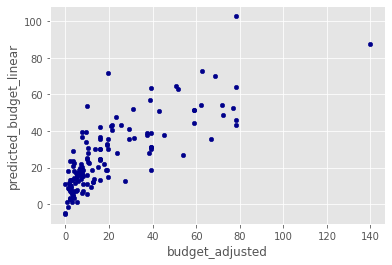

In [6]:
# Linear Regresssion
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)
cv_results = cross_val_score(reg, X, y, cv=5)
print("5-fold cross validation score is :", np.mean(cv_results))
# Now oredict 2019 budget
budget_pred_linear = reg.predict(X_2019)
df_2019_budget['predicted_budget_linear'] = budget_pred_linear

df_2019_budget.head()
df_2019_budget.plot.scatter(x='budget_adjusted', y='predicted_budget_linear',c='DarkBlue')

### Ridge Regression

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


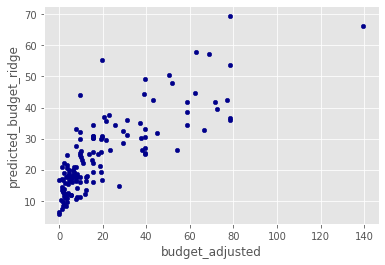

In [12]:
# Ridge regression

from sklearn.linear_model import Ridge

ridge_scores = [];
alphas = [0.001, 0.01, 0.1, 1, 10]
for alpha in alphas:
    ridge = Ridge(alpha= alpha, normalize=True) 
    cv_results = cross_val_score(ridge, X, y, cv=5)
    ridge_scores.append(np.mean(cv_results))

ridge = Ridge(alpha= 1, normalize=True) 
ridge.fit(X, y)
# Now oredict 2019 budget
budget_pred_ridge = ridge.predict(X_2019)
df_2019_budget['predicted_budget_ridge'] = budget_pred_ridge
df_2019_budget.head()
df_2019_budget.plot.scatter(x='budget_adjusted', y='predicted_budget_ridge',c='DarkBlue')

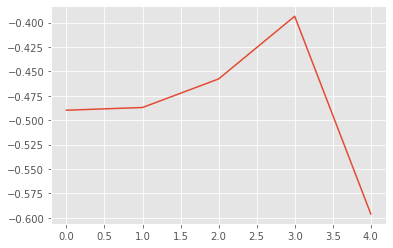

In [11]:
plt.plot(ridge_scores)

### Lasso Regression

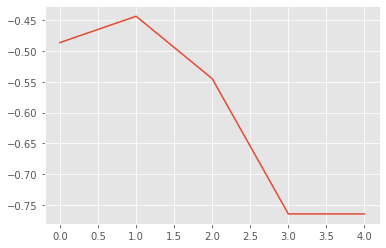

In [14]:
# Lasso Regression
from sklearn.linear_model import Lasso

lasso_scores = [];
alphas = [0.001, 0.01, 0.1, 1, 10]
for alpha in alphas:
    lasso = Lasso(alpha= alpha, normalize=True) 
    cv_results = cross_val_score(lasso, X, y, cv=5)
    lasso_scores.append(np.mean(cv_results))

plt.plot(lasso_scores)


5-fold cross validation result: -0.4432747333595528


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


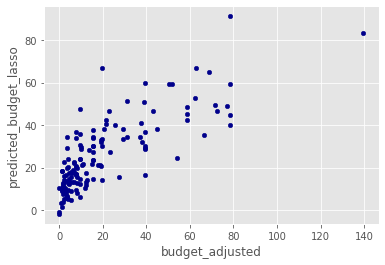

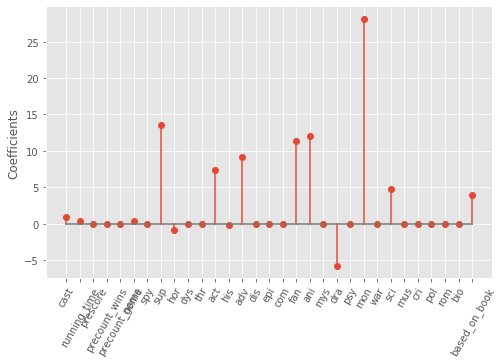

In [15]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01, normalize=True) 
lasso_coef = lasso.fit(X, y)
cv_results = cross_val_score(lasso, X, y, cv=5)
print("5-fold cross validation result:",np.mean(cv_results))

# Now oredict 2019 budget
budget_pred_lasso = lasso.predict(X_2019)
df_2019_budget['predicted_budget_lasso'] = budget_pred_lasso
df_2019_budget.head()
df_2019_budget.plot.scatter(x='budget_adjusted', y='predicted_budget_lasso',c='DarkBlue')

names = X_2019.columns
plt.figure(figsize=(8,5))
_ = plt.stem(range(len(names)), lasso_coef.coef_)
_ = plt.xticks(range(len(names)), names, rotation=60) 
_ = plt.ylabel('Coefficients')


In [422]:
df_2019_budget.head()

,imdbID,title,year,cast,running_time,budget_adjusted,predicted_budget_linear,predicted_budget_ridge,predicted_budget_lasso
0,tt4154796,avengers: endgame,2019,16.0,181.0,139.607843,87.555282,84.301830,83.123505
1,tt1979376,toy story 4,2019,13.0,100.0,78.431373,43.459834,42.159902,39.993678
2,tt4154664,captain marvel,2019,10.0,124.0,68.627451,70.089348,68.633978,65.029524
3,tt6320628,spider-man: far from home,2019,10.0,129.0,62.745098,72.772710,70.765738,67.074276
4,tt4520988,frozen ii,2019,4.0,103.0,58.823529,51.422637,48.814807,45.133101


In [423]:
df_2019_budget['error'] = df_2019_budget.budget_adjusted - df_2019_budget.predicted_budget_lasso
df_2019_budget.sort_values(by = 'error').head(100).tail()

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,imdbID,title,year,cast,running_time,budget_adjusted,predicted_budget_linear,predicted_budget_ridge,predicted_budget_lasso,error
93,tt7131622,once upon a time in hollywood,2019,10.0,161.0,37.647059,37.606296,39.998137,40.773822,-3.126763
21,tt4504044,the prodigy,2019,3.0,92.0,2.352941,2.584469,3.200513,5.453912,-3.100971
77,tt5113040,the secret life of pets 2,2019,13.0,86.0,31.372549,36.284634,35.236817,34.268374,-2.895825
50,tt4913966,the curse of la llorona,2019,3.0,93.0,3.529412,4.399505,4.778836,6.168927,-2.639515
20,tt8128188,high flying bird,2019,7.0,91.0,0.784314,1.118469,2.843767,3.389734,-2.605420


Since the Lasso Regression gave the best prediction, we will impute the missing values for the Budget information with the Lasso Predictions

In [424]:
df_2019_budget[df_2019_budget.budget_adjusted.isnull()].head()

,imdbID,title,year,cast,running_time,budget_adjusted,predicted_budget_linear,predicted_budget_ridge,predicted_budget_lasso,error
10,tt2728784,after darkness,2019,3.0,98.0,NaN,7.401147,8.243467,7.787931,NaN
12,tt5316540,close,2019,4.0,94.0,NaN,8.667807,9.602786,9.871065,NaN
30,tt8323104,nancy drew and the hidden staircase,2019,3.0,89.0,NaN,3.277139,4.385340,3.788991,NaN
31,tt5977276,the aftermath,2019,3.0,108.0,NaN,9.149611,9.841444,10.946917,NaN
34,tt6643972,triple threat,2019,8.0,96.0,NaN,19.841941,19.799002,19.727362,NaN


In [425]:
missing_index = df_mega_2019[df_mega_2019.budget_adjusted.isnull()].index
df_mega_2019.loc[missing_index,'budget_adjusted'] = df_2019_budget.loc[missing_index,'predicted_budget_lasso']

In [426]:
df_mega_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 0 to 233
Data columns (total 50 columns):
imdbID                 234 non-null object
title                  234 non-null object
year                   234 non-null int64
n_votes                234 non-null int64
imdb_rating            234 non-null float64
budget                 142 non-null float64
box_office             162 non-null float64
cast                   234 non-null float64
genre                  234 non-null int64
running_time           234 non-null float64
inflation_factor       234 non-null float64
budget_adjusted        234 non-null float64
budget_per_actor       142 non-null float64
budget_per_time        142 non-null float64
runtime_per_actor      234 non-null float64
percent_revenue        128 non-null float64
total_ratings          234 non-null float64
book                   234 non-null int64
sup                    234 non-null float64
hor                    234 non-null int64
com                    234 

## Regression based estimate of Box office Information

Several movies in 2019 have missing budget information and, for many of the films, it is too early to obtain the box office information. We therefore use the following columns to obtain these numbers through linear regression. The columns used are:
1. Cast size
2. Running time 
3. Genre Size
4. Genre
5. Oscar Prescore
6. Budget

### Predict Box Office Earnings with Lasso 

In [427]:
# Define all the columns
basic_ID_columns = ['imdbID', 'title', 'year', 'cast', 'running_time']
genre_columns = ['genre', 'spy', 'sup', 'hor', 'dys', 'thr', 'act',
       'his', 'adv', 'dis', 'epi', 'com', 'fan', 'ani', 'mys', 'dra', 'psy',
       'mon', 'war', 'sci', 'mus', 'cri', 'oth', 'pol', 'rom', 'bio',
       'based_on_book']
imdb_columns = ['n_votes', 'imdb_rating']
pre_oscar_columns = ['prescore', 'precount_wins', 'precount_noms']
post_oscar_columns = ['postscore', 'win', 'nom']
derived_columns = ['budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings']
budget_columns = ['budget', 'inflation_factor','budget_adjusted']
box_office_columns = ['box_office']

-0.6948872534888266


/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the p

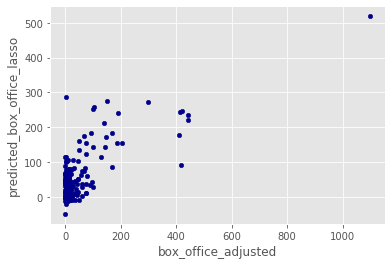

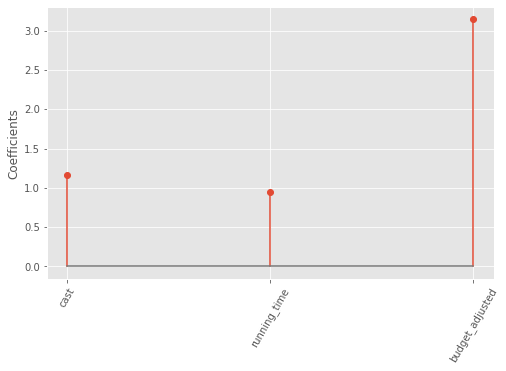

In [436]:
# all_predictors = imdb_columns + pre_oscar_columns + ['genre']
all_predictors = basic_ID_columns + ['budget_adjusted']

X = df_mega[all_predictors].drop(['imdbID', 'title', 'year'], axis=1)
X_2019 = df_mega_2019[all_predictors].drop(['imdbID', 'title', 'year'], axis=1)
y = df_mega['box_office_adjusted']
y_2019 = df_mega_2019['box_office_adjusted']

df_2019_boxof = df_mega_2019[basic_ID_columns + ['box_office_adjusted']]

lasso = Lasso(alpha=0.01, normalize=True) 
lasso_coef = lasso.fit(X, y)
cv_results = cross_val_score(lasso, X, y, cv=5)
print(np.mean(cv_results))

# Now oredict 2019 budget
boxof_pred_lasso = lasso.predict(X_2019)
df_2019_boxof['predicted_box_office_lasso'] = boxof_pred_lasso
df_2019_boxof['error'] = df_2019_boxof['predicted_box_office_lasso'] - df_2019_boxof['box_office_adjusted']

df_2019_boxof.head()
df_2019_boxof.plot.scatter(x='box_office_adjusted', y='predicted_box_office_lasso',c='DarkBlue')

names = X_2019.columns
plt.figure(figsize=(8,5))
_ = plt.stem(range(len(names)), lasso_coef.coef_)
_ = plt.xticks(range(len(names)), names, rotation=60) 
_ = plt.ylabel('Coefficients')

In [30]:
df_2019_boxof.head()

NameError: name 'df_2019_boxof' is not defined

In [439]:
missing_index = df_mega_2019[df_mega_2019.box_office_adjusted.isnull()].index
df_mega_2019.loc[missing_index,'box_office_adjusted'] = df_2019_boxof.loc[missing_index,'predicted_box_office_lasso']

In [440]:
df_mega_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 0 to 233
Data columns (total 50 columns):
imdbID                 234 non-null object
title                  234 non-null object
year                   234 non-null int64
n_votes                234 non-null int64
imdb_rating            234 non-null float64
budget                 142 non-null float64
box_office             162 non-null float64
cast                   234 non-null float64
genre                  234 non-null int64
running_time           234 non-null float64
inflation_factor       234 non-null float64
budget_adjusted        234 non-null float64
budget_per_actor       142 non-null float64
budget_per_time        142 non-null float64
runtime_per_actor      234 non-null float64
percent_revenue        128 non-null float64
total_ratings          234 non-null float64
book                   234 non-null int64
sup                    234 non-null float64
hor                    234 non-null int64
com                    234 

In [441]:
df_mega_2019.budget_per_actor = df_mega_2019.budget_adjusted/df_mega_2019.cast
df_mega_2019.budget_per_time = df_mega_2019.budget_adjusted/df_mega_2019.running_time
df_mega_2019.runtime_per_actor = df_mega_2019.running_time/df_mega_2019.cast
df_mega_2019.percent_revenue = 100*(df_mega_2019.box_office_adjusted - df_mega_2019.budget_adjusted)/df_mega_2019.budget_adjusted 

In [442]:
df_mega_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 0 to 233
Data columns (total 50 columns):
imdbID                 234 non-null object
title                  234 non-null object
year                   234 non-null int64
n_votes                234 non-null int64
imdb_rating            234 non-null float64
budget                 142 non-null float64
box_office             162 non-null float64
cast                   234 non-null float64
genre                  234 non-null int64
running_time           234 non-null float64
inflation_factor       234 non-null float64
budget_adjusted        234 non-null float64
budget_per_actor       234 non-null float64
budget_per_time        234 non-null float64
runtime_per_actor      234 non-null float64
percent_revenue        234 non-null float64
total_ratings          234 non-null float64
book                   234 non-null int64
sup                    234 non-null float64
hor                    234 non-null int64
com                    234 

In [444]:
df_mega_2019.to_csv('my_data_4/DF_MEGA_2019_updated.csv')